In [1]:
import sys, os
sys.path.append("../../models/PFN")
sys.path.append(os.path.abspath('../../fastjet-install/lib/python3.9/site-packages'))
from dataset_pfn import PFNDataset, processed2tau
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from augmented_pfn_model import AugParticleFlowNetwork as Model
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
all_models = [f for f in os.listdir("../../models/PFN/trained_models") if "_best" in f and "_aug" in f]
print("\n".join(all_models))

PFN_best_v3_aug
PFN_best_baseline4_aug
PFN_best_v4_aug


In [3]:
test_path = "../../datasets/test.h5"

#Loading testing dataset
test_set = PFNDataset(test_path, preprocessed=True)
testloader = DataLoader(test_set, shuffle=True, batch_size=500, num_workers=4, pin_memory=True, persistent_workers=True)

In [4]:
def eval2(model):
    labels = []
    preds = []
    with torch.no_grad():
        for x,m,y,_ in tqdm(testloader):
            x = x.cuda()
            m = m.cuda()
            pred = model(x, m)
            labels.append(y[:,1].cpu().numpy())
            preds.append(pred[:,1].cpu().numpy())
    labels = np.concatenate(labels, axis=None)
    preds = np.concatenate(preds, axis=None)
    return labels, preds

In [5]:
def evalFC(model, data, mask_indices = [-1], mask_values = [0.]):
    lfs = data.cuda()
    for mask_index, mask_value in zip(mask_indices, mask_values):
        if mask_index >= 0:
            lfs[:, mask_index] = mask_value*torch.ones(lfs[:, mask_index].shape)  
    for ii, layer in enumerate(FcLayers):
        if ii == len(FcLayers)-1: 
            res = layer.forward(lfs).cpu()
        elif ii == len(FcLayers)-2:
            lfs = layer.forward(lfs)
            psmax = lfs.cpu()
        else:
            lfs = layer.forward(lfs)
    return psmax, res

def evalPHI(model, test_set, d_mean = [], mask_indices = []):
    myDL = DataLoader(test_set, batch_size=1024)
    with torch.no_grad():
        for idx, (d, m, l, ad) in enumerate(myDL):
            # for mask_index in mask_indices:
            #     try:
            #         d[:, mask_index[0], mask_index[1]] = d_mean[mask_index[0], mask_index[1]]
            #     except:
            #         d[:, mask_index[0], mask_index[1]] = d_mean[mask_index[1]]
            d2 = torch.flatten(d, start_dim=0, end_dim=1)
            lfs = model._modules['phi'].forward(d2.cuda())
            lfs = torch.stack(torch.split(lfs.permute(1, 0), 200, dim=1), 0)
            lfs = lfs * m.cuda().bool().float()
            lfs = lfs.sum(-1)
            this_lfs = lfs.cpu()
            this_taus = processed2tau(d,ad)
            psmax, res = evalFC(model, 
                                torch.cat((lfs, this_taus.cuda()[:,:7]),1).float())
            # res = model._modules['fc'].forward(lfs)
            if idx == 0:
                latents = this_lfs.cpu()
                labels = l.cpu()
                presoftmax = psmax.cpu()
                preds = res.cpu()
                aug_data = ad.cpu()
                taus = this_taus.cpu()
            else:
                latents = torch.cat((latents, this_lfs.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                presoftmax  = torch.cat((presoftmax, psmax.cpu()), 0)
                preds  = torch.cat((preds, res.cpu()), 0)
                aug_data = torch.cat((aug_data, ad.cpu()), 0)
                taus = torch.cat((taus, this_taus.cpu()), 0)
            if idx == 1000:
                break
    return latents, labels, presoftmax, preds, aug_data, taus


[100, 100, 64] [64, 100, 100]
PFN_best_v3_aug 		 Params: 38374	 ROC-AUC: 97.93%, Accuracy: 92.79%, BRR: 664.19
[100, 100, 256] [100, 100, 100]


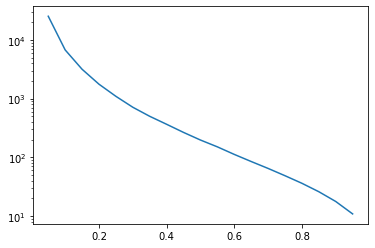

PFN_best_baseline4_aug 		 Params: 83158	 ROC-AUC: 98.00%, Accuracy: 92.89%, BRR: 710.96
[100, 100, 32] [64, 100, 100]
PFN_best_v4_aug 		 Params: 33094	 ROC-AUC: 97.86%, Accuracy: 92.66%, BRR: 613.72


Closing remaining open files:../../datasets/test.h5...

In [7]:
#loading model
#all_models = ['PFN_best_v9_augmented']
for modelname in all_models:
    model_dict = json.load(open("../../models/PFN/trained_model_dicts/" + modelname.replace("_best","").replace("baseline4", "baseline") + ".json"))
    #print(modelname, model_dict)
    label = model_dict['label']
    f_nodes = list(map(int, model_dict['f_nodes'].split(',')))
    phi_nodes = list(map(int, model_dict['phi_nodes'].split(',')))

    model = Model(input_dims=3, Phi_sizes=phi_nodes, F_sizes=f_nodes).cuda()
    model.load_state_dict(torch.load("../../models/PFN/trained_models/" + modelname ))
    nparams = sum(p.numel() for p in model.parameters())
    
    FcLayers = []
    PhiLayers = []
    for layer in model._modules['fc']:
        #print(layer)
        FcLayers.append(layer)
    #print('\n')
    for layer in model._modules['phi']:
        #print(layer)
        PhiLayers.append(layer)
    
    _, labels, _, preds, _, _ = evalPHI(model, test_set, d_mean = [], mask_indices = [])
    labels = labels[:,1]
    preds = preds[:,1]
    #labels, preds = eval2(model)
    accuracy = accuracy_score(labels, preds.round())*100
    
    auc = roc_auc_score(labels, preds)*100
    
    fpr, tpr, thresholds = roc_curve(labels, preds, drop_intermediate=False)
    intrp = interpolate.interp1d(tpr, fpr)
    if 'baseline' in modelname:
        eS = np.array(list(range(1,20)))*0.05
        inveB = []
        for es in eS:
            inveB.append(1./intrp(es))
        plt.figure()
        plt.plot(eS, inveB)
        plt.yscale("log")
        plt.show()
    brr = 1./intrp(0.3)
    print("{} \t\t Params: {}\t ROC-AUC: {:.2f}%, Accuracy: {:.2f}%, BRR: {:.2f}".format(modelname,nparams,auc,accuracy,brr))
    #print(modelname, "\t", "ROC-AUC: {:.4f}% Accuracy: {:.4f}%".format(auc, accuracy))